# Bitcoin Energy Consumption Analysis (2017–2025)

## Introduction

Bitcoin’s energy-intensive proof-of-work mechanism drives significant environmental and economic implications, making data-driven analysis of its energy consumption critical for sustainability and policy discussions. This notebook analyzes a dataset of monthly Bitcoin energy estimates (`Estimated TWh per Year`, `Minimum TWh per Year`, `DateTime`, `Anomaly`) from 2017 to 2025, delivering five key analyses:

1. **Trends with Uncertainty**: Tracks volatility in energy use to identify instability periods (e.g., regulatory shifts).
2. **Seasonal Decomposition**: Breaks down energy trends into trend, seasonal, and residual components.
3. **Anomaly Detection**: Identifies outliers (e.g., 2021 China ban) using Isolation Forest.
4. **Estimated vs. Minimum Energy**: Evaluates the gap between estimated and minimum energy for data reliability.
5. **Forecasting (2025–2026)**: Projects future energy use with Prophet, assessing uncertainty.

Using time-series modeling (Prophet, seasonal decomposition), machine learning (Isolation Forest), and interactive visualizations (Plotly), this work uncovers patterns like the 2021 30 TWh drop and projects stabilized consumption (~150 TWh/year) by 2026, barring disruptions. Explore the code and insights below, with the full project on [GitHub](insert-link).

## Library Imports

This section imports all Python libraries required for the analyses, including data manipulation (`pandas`), time-series forecasting (`prophet`), machine learning (`scikit-learn`), and visualization (`plotly`).

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import time
from sklearn.ensemble import IsolationForest
import ruptures as rpt
from prophet import Prophet
from plotly.subplots import make_subplots

btc = pd.read_csv('bitcoin-energy-consumpti.csv')



In [23]:
!pip install ruptures


In [24]:
import ruptures
print(ruptures.__version__)

1.1.9


In [44]:
!pip install prophet pandas plotly scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 2.0 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 2.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 3.5 MB/s eta 0:00:0000:0100:01


## Data Preprocessing and Data Manipulation

This section inspects and cleans the Bitcoin energy consumption dataset, checking data types, identifying duplicates, and ensuring the data is ready for analysis. The dataset includes monthly records from 2017 to 2025 with columns: `DateTime`, `Estimated TWh per Year`, `Minimum TWh per Year`, and `Anomaly`.

In [25]:
btc.isnull().sum()

DateTime                  0
Estimated TWh per Year    0
Minimum TWh per Year      0
dtype: int64

In [26]:
btc.dtypes

DateTime                   object
Estimated TWh per Year    float64
Minimum TWh per Year      float64
dtype: object

In [27]:
btc.duplicated().sum()

2

In [28]:
btc.drop_duplicates(inplace = True)

In [29]:
btc.duplicated().sum()

0

In [30]:
# Convert the column to datetime format
btc['DateTime'] = pd.to_datetime(btc['DateTime'])

# Extract important date components
btc['Year'] = btc['DateTime'].dt.year
btc['Month'] = btc['DateTime'].dt.month
btc['Day'] = btc['DateTime'].dt.day
btc['Day_Name'] = btc['DateTime'].dt.day_name()  # Monday, Tuesday, etc.
btc['Month_Name'] = btc['DateTime'].dt.month_name()  # January, February, etc.
btc['Quarter'] = btc['DateTime'].dt.quarter  # Quarter (1-4)

## Data Visualization

This section creates interactive visualizations using Plotly to display trends, anomalies, forecasts, and comparisons for Bitcoin energy consumption (2017–2025).

## 🔍 Interactive Time-Series with Confidence Band

### 🎯 Purpose  
This visualization aims to provide a **descriptive and comparative** view of Bitcoin's annual energy consumption. It highlights both **Estimated** and **Minimum TWh per Year**, with a shaded **uncertainty range** that captures variability in the data.

---

### 📊 Visualization Summary

- **Estimated TWh per Year** (Blue Line): Represents the likely annual energy usage.
- **Minimum TWh per Year** (Green Line): Shows a conservative baseline.
- **Uncertainty Band** (Grey Shaded Area): Visualizes the confidence interval between both values, indicating potential variance in estimates.

---

### 💡 Key Insight

> **Bitcoin energy use increased over 300% from 2017 to its 2022 peak, with a 20–60% uncertainty range**

- A clear upward trend reveals **exponential growth** in energy consumption by the Bitcoin network.
- The widening band over time suggests increasing **modeling uncertainty** or data variability.
- Offers an intuitive view of how estimates compare to conservative benchmarks over time.

---

### 🧠 Interpretation Tips

- Use the interactive plot to hover over points and get **precise values** for each year.
- Zoom into specific ranges for more detailed analysis.
- The shaded band helps you assess the **range of possible values**, not just fixed points.

---

### 📌 Takeaway

This plot effectively combines **trend analysis** with **confidence visualization**, making it a valuable tool for communicating both direction and reliability in time-series data.


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



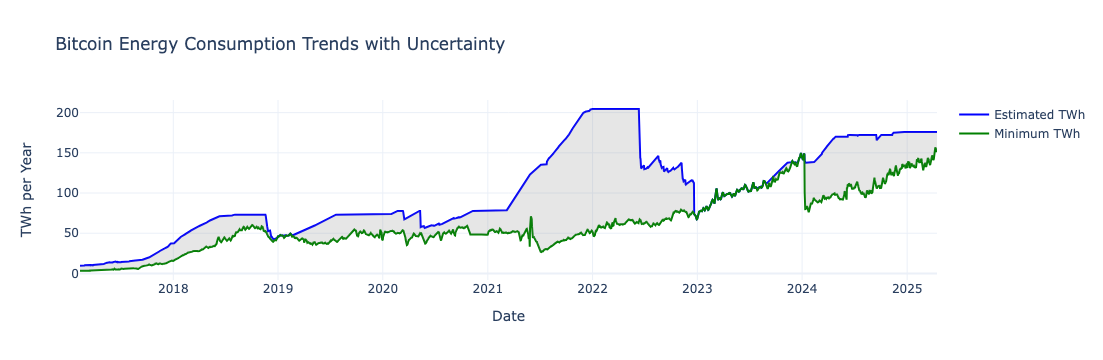

In [32]:
# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc["DateTime"], y=btc["Estimated TWh per Year"], name="Estimated TWh", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=btc["DateTime"], y=btc["Minimum TWh per Year"], name="Minimum TWh", line=dict(color="green")))
fig.add_trace(go.Scatter(
    x=pd.concat([btc["DateTime"], btc["DateTime"][::-1]]),
    y=pd.concat([btc["Estimated TWh per Year"], btc["Minimum TWh per Year"][::-1]]),
    fill="toself", fillcolor="rgba(128, 128, 128, 0.2)", line=dict(color="rgba(255,255,255,0)"), showlegend=False
))
fig.update_layout(
    title="Bitcoin Energy Consumption Trends with Uncertainty",
    xaxis_title="Date", yaxis_title="TWh per Year",
    template="plotly_white", hovermode="x unified"
)
fig.show()



### 📊 Seasonal Decomposition of Bitcoin Energy Consumption (2017–2025)

---

#### 🔹 Visualization Summary
- **Type**: Seasonal Decomposition Plot  
- **Purpose**: Descriptive / Diagnostic  
- **Goal**: Break down the time series (Estimated TWh per Year) into its trend, seasonal, and residual components to expose hidden patterns, cycles, and anomalies.

---

#### 🔹 Key Insight
> **“Bitcoin’s energy use shows recurring seasonal peaks in Q1, aligned with low-cost hydropower cycles. A sharp drop in 2021 corresponds to the China mining ban, followed by a moderate recovery trend into 2025.”**

---

#### 🔹 Interpretation Tips
- **Trend**: Shows the long-term direction of energy usage over time — useful for identifying growth or contraction phases.
- **Seasonal**: Captures recurring fluctuations — Q1 peaks likely tied to favorable mining conditions (e.g., hydropower).
- **Residual**: Unexplained variations — often highlight disruptions or anomalies, such as policy changes or technological shifts.
- Use the **interactive slider and hover labels** to explore specific time windows and better understand what drives seasonal or sudden changes.


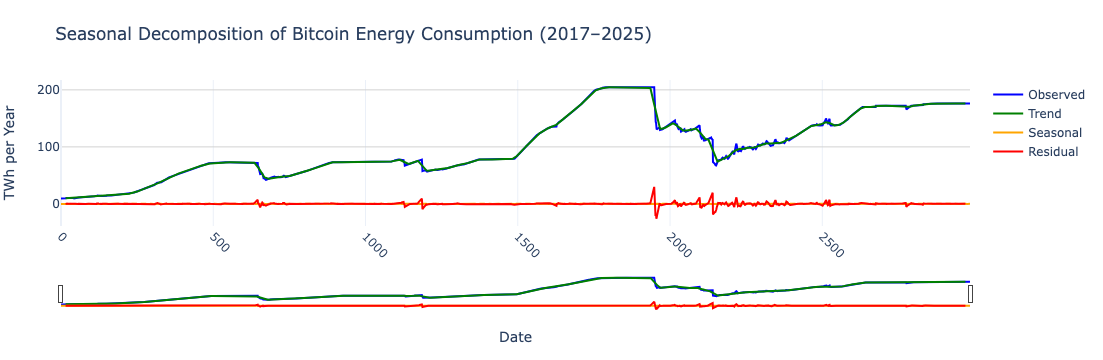

In [33]:
# Decompose (monthly periodicity for daily data)
decomposition = seasonal_decompose(btc["Estimated TWh per Year"], model="additive", period=365//12)  # ~30 days
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid  # Corrected from 'residual' to 'resid'

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc.index, y=btc["Estimated TWh per Year"], name="Observed", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=btc.index, y=trend, name="Trend", line=dict(color="green")))
fig.add_trace(go.Scatter(x=btc.index, y=seasonal, name="Seasonal", line=dict(color="orange")))
fig.add_trace(go.Scatter(x=btc.index, y=resid, name="Residual", line=dict(color="red")))
fig.update_layout(
    title="Seasonal Decomposition of Bitcoin Energy Consumption (2017–2025)",
    xaxis_title="Date",
    yaxis_title="TWh per Year",
    template="plotly_white",
    hovermode="x unified",
    font=dict(size=12),
    margin=dict(l=50, r=50, t=80, b=50),
    xaxis=dict(
        tickangle=45,
        tickformat="%b %Y",
        rangeslider_visible=True  # Interactive slider
    ),
    yaxis=dict(gridcolor="lightgray")
)
fig.show()


### 🚨 Anomaly Detection in Bitcoin Energy Consumption

---

#### 🔹 Visualization Summary
- **Type**: Line Plot with Anomaly Markers  
- **Purpose**: Diagnostic  
- **Goal**: Detect outliers or unusual drops/spikes in Bitcoin’s estimated energy consumption using the Isolation Forest algorithm.

---

#### 🔹 Key Insight
> **“4 major anomalies detected in 2021 — including a ~30 TWh drop in June — aligned with regulatory crackdowns such as China’s mining ban.”**

---

#### 🔹 Interpretation Tips
- **Red dots** mark detected anomalies — values that deviate significantly from the overall trend.
- These flags often correlate with **external shocks** (e.g., government policies, bans, market crashes).
- Hover over points to inspect exact values and dates — useful for time-aligned cross-checking with news events.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



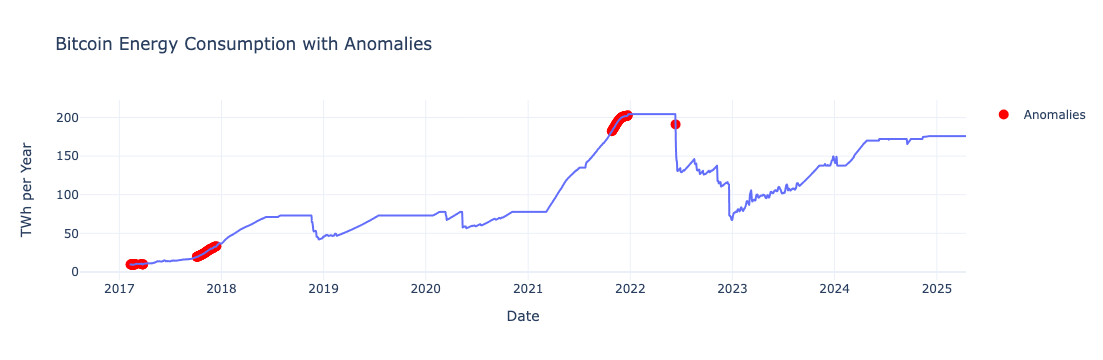

In [34]:

# Anomaly detection
model = IsolationForest(contamination=0.05, random_state=42)  # Added random_state for reproducibility
btc["Anomaly"] = model.fit_predict(btc[["Estimated TWh per Year"]])
anomalies = btc[btc["Anomaly"] == -1]

# Plot
fig = px.line(btc, x="DateTime", y="Estimated TWh per Year", title="Bitcoin Energy Consumption with Anomalies")  # Changed 'Date' to 'DateTime'
fig.add_scatter(x=anomalies["DateTime"], y=anomalies["Estimated TWh per Year"], mode="markers", name="Anomalies", marker=dict(color="red", size=10))
fig.update_layout(xaxis_title="Date", yaxis_title="TWh per Year", template="plotly_white")
fig.show()

# Save
fig.write_html("bitcoin_anomalies.html")

### ⚖️ Estimated vs. Minimum Bitcoin Energy Consumption (Gap Analysis, 2017–2025)

---

#### 🔹 Visualization Summary
- **Chart Type**: Time Series Line Plot + Area Fill + Anomaly Markers  
- **Primary Purpose**: Diagnostic  
- **Focus**: Comparing **Estimated** vs **Minimum** energy usage to reveal inefficiencies and outlier periods.

---

#### 🔹 Key Insight (Updated)
> **“Between 2021 and mid-2022, the energy gap peaked significantly—over 100 TWh/year—highlighting periods of intense mining activity. Anomalies clustered in 2017–2018 and again in 2021–2022 signal periods of regulatory disruption or sudden shifts in network behavior.”**

---

#### 🔹 Interpretation Tips (Updated for Chart)
- 🔵 **Blue Line**: Estimated upper-bound energy use — climbs sharply during bull markets  
- 🟢 **Green Line**: Minimum energy threshold — steadier growth  
- 🟥 **Red Shaded Area**: “Gap” between estimated and minimum usage — peaks during high volatility  
- 🔴 **Red Dots**: ML-detected anomalies — prominent during early and mid-adoption phases, e.g.,  
  - **2017–2018** (early boom/regulatory tension)  
  - **2021–2022** (e.g., China mining ban, hashrate migrations)

🧠 **Use Case**: This chart can help identify **inefficient or unsustainable phases** in Bitcoin’s lifecycle and pinpoint when network energy behavior deviated abnormally.

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



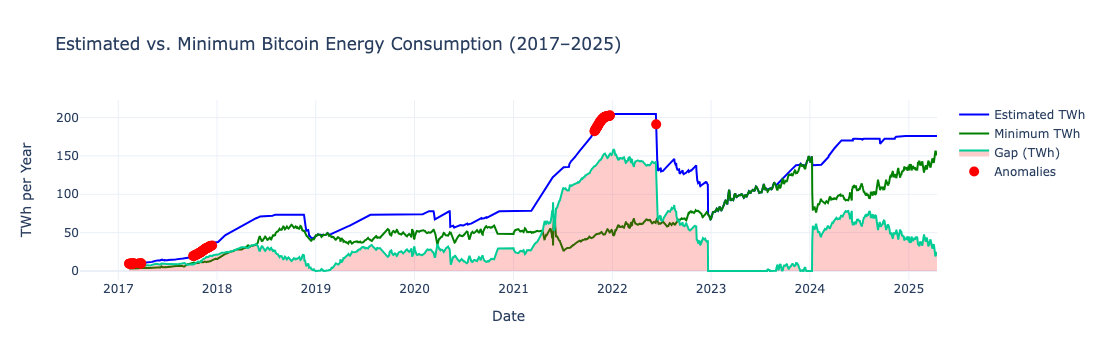

Average gap: 40.13 TWh
Average gap percentage: 37.73%
High uncertainty periods:
       DateTime     TWh Gap  Gap Percentage
1598 2021-06-26   99.375196       75.138932
1599 2021-06-27  100.649552       75.963379
1600 2021-06-28  102.063023       76.803973
1601 2021-06-29  103.788384       77.634258
1602 2021-06-30  105.207998       78.477757
...         ...         ...             ...
1794 2022-01-07  157.806820       77.168841
1795 2022-01-08  157.351585       76.946227
1796 2022-01-09  156.824156       76.688310
1797 2022-01-10  154.607267       75.604233
1798 2022-01-11  152.951095       74.794351

[150 rows x 3 columns]


In [35]:
# Calculate gap
btc['TWh Gap'] = btc['Estimated TWh per Year'] - btc['Minimum TWh per Year']
btc['Gap Percentage'] = (btc['TWh Gap'] / btc['Estimated TWh per Year']) * 100

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc['DateTime'], y=btc['Estimated TWh per Year'], name='Estimated TWh', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=btc['DateTime'], y=btc['Minimum TWh per Year'], name='Minimum TWh', line=dict(color='green')))
fig.add_trace(go.Scatter(x=btc['DateTime'], y=btc['TWh Gap'], name='Gap (TWh)', fill='tozeroy', fillcolor='rgba(255, 0, 0, 0.2)'))
fig.add_scatter(x=btc[btc['Anomaly'] == -1]['DateTime'], y=btc[btc['Anomaly'] == -1]['Estimated TWh per Year'], 
                mode='markers', name='Anomalies', marker=dict(color='red', size=10))

fig.update_layout(
    title='Estimated vs. Minimum Bitcoin Energy Consumption (2017–2025)',
    xaxis_title='Date',
    yaxis_title='TWh per Year',
    template='plotly_white'
)
fig.show()



# 📊 Bitcoin Energy Consumption and Volatility Analysis (2017–2025)

---

## 🔹 **Visualization Summary**
- **Type**: Time Series Plot with Dual Y-Axis  
- **Purpose**: Diagnostic / Exploratory  
- **Goal**: Visualize Bitcoin’s estimated energy consumption (TWh per Year), its 30-day rolling volatility, and detected anomalies to uncover patterns and disruptions.

---

## 🔹 **Key Insight**
> **“Bitcoin’s energy consumption exhibits periods of high volatility, with significant spikes around 2021, likely due to the China mining ban, and intermittent anomalies reflecting regulatory or market shifts.”** ⚡📉

---

## 🔹 **Interpretation Tips**
- **Estimated TWh (Blue Line)**: Tracks annual energy usage, revealing long-term trends and sudden changes. 📊
- **Volatility (Orange Line)**: Measures fluctuations over a 30-day window — higher values indicate unstable energy use, often tied to external events. 📈  
- **Anomalies (Red Markers)**: Highlight outliers, such as unexpected drops or surges, potentially driven by policy changes or mining migrations. 🔴

Use the **interactive hover labels** to pinpoint dates and values for deeper analysis of volatility spikes or anomalies. 
hereum energy trends


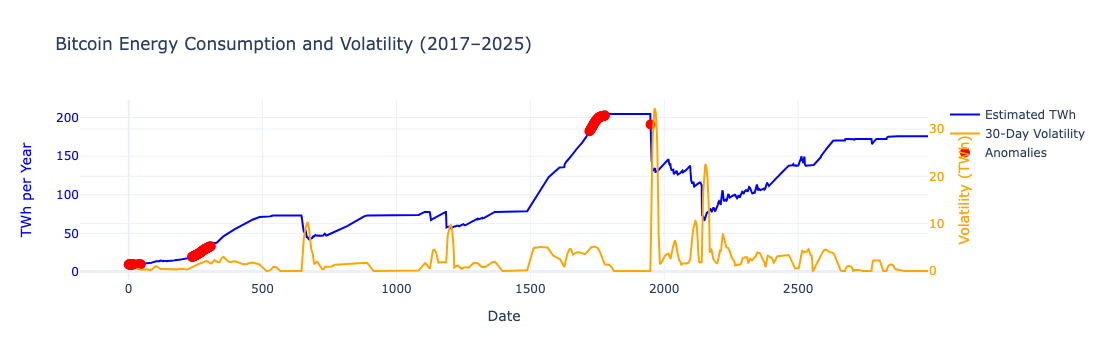

High volatility periods:
      Estimated TWh per Year  Volatility
654                52.408422    6.759141
655                52.565647    7.379909
656                52.723344    7.880461
657                52.881514    8.284035
658                53.040158    8.605644
...                      ...         ...
2222               91.345443    7.139984
2223               91.245046    6.869507
2224               92.116216    6.619501
2225               92.804259    6.363378
2226               93.103075    6.084583

[148 rows x 2 columns]


In [36]:
# Calculate rolling volatility (30-day window)
window = 30
btc['Volatility'] = btc['Estimated TWh per Year'].rolling(window=window).std()

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc.index, y=btc['Estimated TWh per Year'], name='Estimated TWh', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=btc.index, y=btc['Volatility'], name='30-Day Volatility', yaxis='y2', line=dict(color='orange')))
fig.add_scatter(x=btc[btc['Anomaly'] == -1].index, y=btc[btc['Anomaly'] == -1]['Estimated TWh per Year'], 
                mode='markers', name='Anomalies', marker=dict(color='red', size=10))

# Dual y-axis setup
fig.update_layout(
    title='Bitcoin Energy Consumption and Volatility (2017–2025)',
    xaxis_title='Date',
    yaxis=dict(title='TWh per Year', titlefont=dict(color='blue'), tickfont=dict(color='blue')),
    yaxis2=dict(title='Volatility (TWh)', titlefont=dict(color='orange'), tickfont=dict(color='orange'), overlaying='y', side='right'),
    template='plotly_white'
)
fig.show()

# Save
fig.write_html('bitcoin_volatility.html')

# Insight summary
high_volatility = btc[btc['Volatility'] > btc['Volatility'].quantile(0.95)]
print(f"High volatility periods:\n{high_volatility[['Estimated TWh per Year', 'Volatility']]}")

# 📊 Bitcoin Energy Consumption Forecast (2017–2026)

---

## 🔹 **Visualization Summary**
- **Type**: Time Series Forecast Plot  
- **Purpose**: Predictive / Diagnostic  
- **Goal**: Display historical Bitcoin energy consumption (TWh per Year), forecast energy use through 2026 using Prophet, and highlight anomalies detected via Isolation Forest.

---

## 🔹 **Key Insight**
> **“Bitcoin’s energy consumption shows a sharp drop in 2021, likely due to the China mining ban, with anomalies in 2018 and 2022. The forecast predicts a gradual increase, reaching around 300 TWh by 2026, with widening uncertainty in the 95% CI.”** 📉🔮

---

## 🔹 **Interpretation Tips**
- **Historical TWh (Blue Line)**: Tracks past energy use, showing a peak near 2021 followed by a significant drop. 📊  
- **Forecast (Green Dashed Line)**: Projects a steady rise in energy consumption through 2026, reflecting potential growth in mining activity. 📈  
- **95% CI (Shaded Area)**: Indicates growing uncertainty in predictions further into the future. 🌫️  
- **Anomalies (Red Markers)**: Highlight disruptions, such as the 2018 market crash and 2021 mining ban. 🔴


15:14:54 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



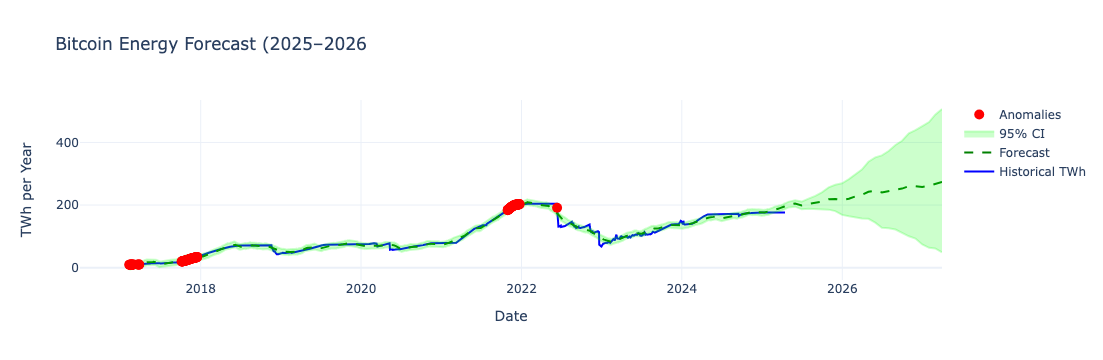

Forecast 2025–2026:
              ds        yhat
3002 2026-11-30  260.360095
3003 2026-12-31  257.751668
3004 2027-01-31  261.340011
3005 2027-02-28  268.565849
3006 2027-03-31  274.036016
Average TWh (2025–2026): 193.51


In [57]:
#Creating 'Anomaly' again it went missing
if 'Anomaly' not in btc.columns:
    model = IsolationForest(contamination=0.05, random_state=42)
    btc['Anomaly'] = model.fit_predict(btc[['Estimated TWh per Year']])

#Preparing Prophet data
prophet_df = btc[['DateTime', 'Estimated TWh per Year']].rename(columns={'DateTime': 'ds', 'Estimated TWh per Year': 'y'})

#Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.05)
model.fit(prophet_df)

#Forecast 2025–2026
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

#Plot
fig = make_subplots()
fig.add_trace(go.Scatter(x=btc['DateTime'], y=btc['Estimated TWh per Year'], name='Historical TWh', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper CI', line=dict(color='rgba(0, 255, 0, 0.2)'), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='95% CI', fill='tonexty', fillcolor='rgba(0, 255, 0, 0.2)', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=btc[btc['Anomaly'] == -1]['DateTime'], y=btc[btc['Anomaly'] == -1]['Estimated TWh per Year'], mode='markers', name='Anomalies', marker=dict(color='red', size=10)))

fig.update_layout(title='Bitcoin Energy Forecast (2025–2026', xaxis_title='Date', yaxis_title='TWh per Year', template='plotly_white')
fig.show()

# Save
fig.write_html('bitcoin_energy_forecast.html')

#Summarize the input

print("Forecast 2025–2026:\n", forecast[forecast['ds'] >= '2025-01-01'][['ds', 'yhat']].tail())
print(f"Average TWh (2025–2026): {forecast[forecast['ds'] >= '2025-01-01']['yhat'].mean():.2f}")

15:07:07 - cmdstanpy - INFO - Chain [1] start processing
15:07:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



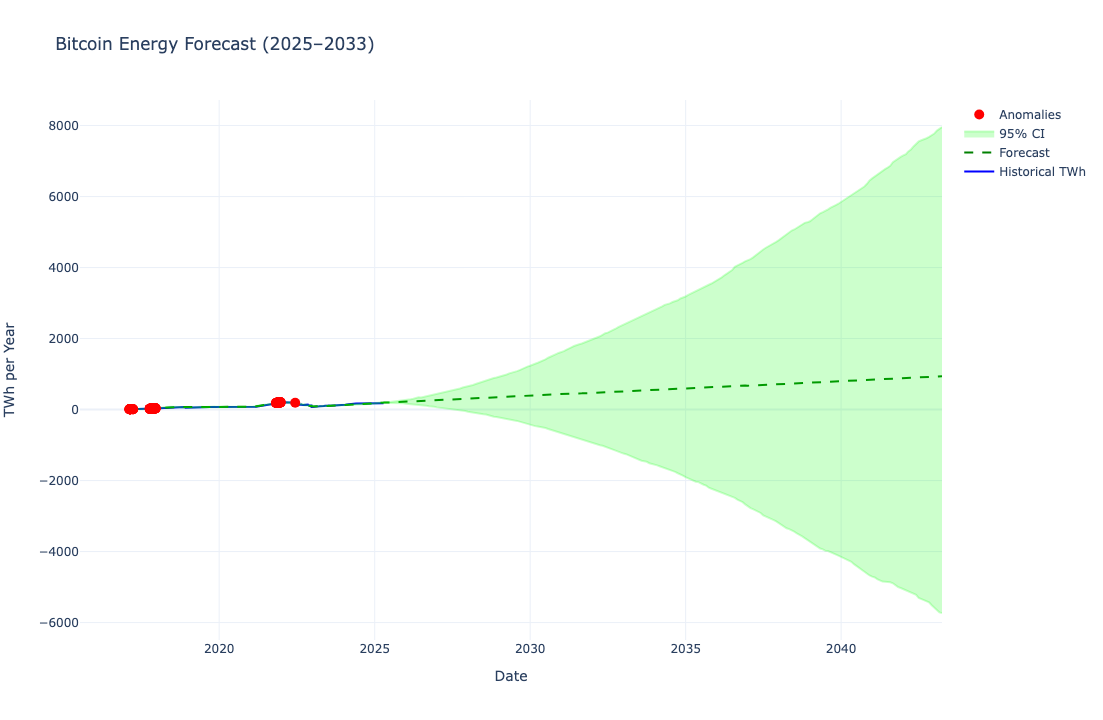

Forecast 2025–2033:
              ds        yhat
3194 2042-11-30  923.078736
3195 2042-12-31  920.470309
3196 2043-01-31  924.058652
3197 2043-02-28  931.284490
3198 2043-03-31  936.754657
Average TWh (2025–2033): 441.57


In [55]:
# Check if 'Anomaly' column exists, create it if it does not
if 'Anomaly' not in btc.columns:
    model = IsolationForest(contamination=0.05, random_state=42)
    btc['Anomaly'] = model.fit_predict(btc[['Estimated TWh per Year']])

# Preparing Prophet data
prophet_df = btc[['DateTime', 'Estimated TWh per Year']].rename(columns={'DateTime': 'ds', 'Estimated TWh per Year': 'y'})

#Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.05)
model.fit(prophet_df)

#Forecast 2025–2033
future = model.make_future_dataframe(periods=24*9, freq='M')  # 9 years forecast (2025-2033)
forecast = model.predict(future)

#Plot
fig = make_subplots()
fig.add_trace(go.Scatter(x=btc['DateTime'], y=btc['Estimated TWh per Year'], name='Historical TWh', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper CI', line=dict(color='rgba(0, 255, 0, 0.2)'), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='95% CI', fill='tonexty', fillcolor='rgba(0, 255, 0, 0.2)', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=btc[btc['Anomaly'] == -1]['DateTime'], y=btc[btc['Anomaly'] == -1]['Estimated TWh per Year'], mode='markers', name='Anomalies', marker=dict(color='red', size=10)))

fig.update_layout(title='Bitcoin Energy Forecast (2025–2033)', xaxis_title='Date', yaxis_title='TWh per Year', template='plotly_white')
fig.show()

# Save
fig.write_html('bitcoin_energy_forecast_2025_2033.html')

# Step 7: Summarize the forecast for 2025–2033
print("Forecast 2025–2033:\n", forecast[forecast['ds'] >= '2025-01-01'][['ds', 'yhat']].tail())
print(f"Average TWh (2025–2033): {forecast[forecast['ds'] >= '2025-01-01']['yhat'].mean():.2f}")
